In [2]:
import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('../data/Churn_Modelling.csv')
data.head()

### 1-2. feature engineering
# 지역 원핫인코딩 실시
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)

# 연속형 변수들을 로그 스케일링 실시 ('Age','Balance')
data['LogAge'] = data['Age'].apply(lambda x: np.log1p(x))
data['LogBalance'] = data['Balance'].apply(lambda x: np.log1p(x))

### 1-3 데이터분할 및 스케일링
# 안쓰는 칼럼 제거
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Age', 'Balance'])

In [14]:
data

,CreditScore,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,LogAge,LogBalance
0,619,2,1,1,1,101348.88,1,1,0,0,1,0,3.761200,0.000000
1,608,1,1,0,1,112542.58,0,0,0,1,1,0,3.737670,11.336294
2,502,8,3,1,0,113931.57,1,1,0,0,1,0,3.761200,11.980813
3,699,1,2,0,0,93826.63,0,1,0,0,1,0,3.688879,0.000000
4,850,2,1,1,1,79084.10,0,0,0,1,1,0,3.784190,11.740155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,5,2,1,0,96270.64,0,1,0,0,0,1,3.688879,0.000000
9996,516,10,1,1,1,101699.77,0,1,0,0,0,1,3.583519,10.957287
9997,709,7,1,0,1,42085.58,1,1,0,0,1,0,3.610918,0.000000
9998,772,3,2,1,0,92888.52,1,0,1,0,0,1,3.761200,11.226260


In [8]:
X = data.drop(columns='Exited')
y = data['Exited']

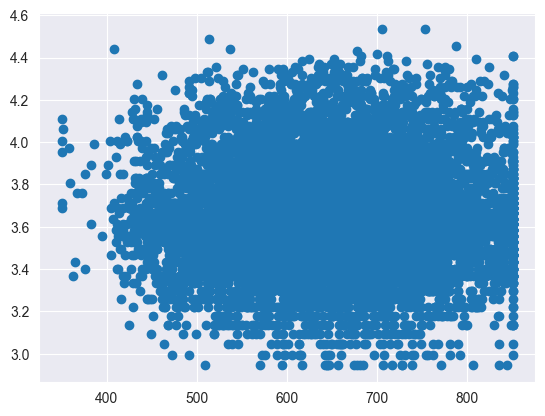

In [20]:
plt.scatter(X.iloc[:,0], X.iloc[:,-2])
plt.show()

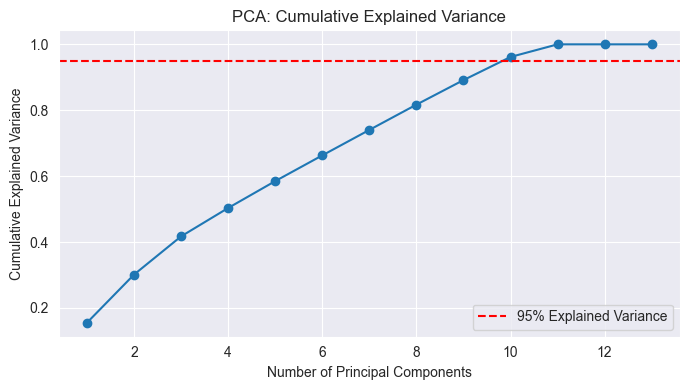

95% 이상의 분산을 설명하는 데 필요한 주성분 수: 10
원본 특성 개수: 13
PCA 적용 후 특성 개수: 10


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
data = pd.read_csv('../data/Churn_Modelling.csv')

# 2. 전처리
# 2-1) 원핫 인코딩 + 로그 변환
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 2-2) 불필요 열 제거 및 특성/타깃 분리
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 3. 학습/테스트 분리 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4. PCA로 차원 축소
# 4-1) 먼저 모든 주성분을 학습해서 누적 설명 분산 비율을 계산
pca_full = PCA()
pca_full.fit(X_train_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# 4-2) 누적 설명 분산 시각화 (0.95 기준)
plt.figure(figsize=(7, 4))
plt.plot(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    linestyle='-'
)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4-3) 95% 이상의 분산을 설명하는 데 필요한 주성분 개수 계산
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"95% 이상의 분산을 설명하는 데 필요한 주성분 수: {n_components_95}")

# 4-4) 최종 PCA 모델 생성 (선택된 주성분 수)
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 5. 결과 확인
print("원본 특성 개수:", X_train_scaled.shape[1])
print("PCA 적용 후 특성 개수:", X_train_pca.shape[1])

# 이제 X_train_pca, X_test_pca를 이용해 모델 학습을 진행합니다.
# 예:
# from sklearn.ensemble import BalancedRandomForestClassifier
# clf = BalancedRandomForestClassifier(...)
# clf.fit(X_train_pca, y_train)
# y_pred = clf.predict(X_test_pca)

array([[ 1.43707971, -0.99026357, -0.67787064, ...,  1.7065786 ,
        -0.01389184, -2.0753114 ],
       [ 0.72053886,  2.30762423, -0.7959308 , ..., -0.66171991,
         0.37970418, -0.73112252],
       [-1.99968326,  1.34599521, -0.36366618, ..., -0.72346389,
         1.50383522, -0.10196755],
       ...,
       [-1.28248243, -1.14337068, -0.71911726, ...,  0.4063992 ,
        -0.43628893,  1.08246972],
       [ 1.1947519 ,  0.79578959,  1.8713333 , ..., -0.29240874,
        -0.86397702, -0.34104417],
       [ 1.34441245,  0.27278275,  2.23833941, ...,  0.89567442,
        -1.82354162, -0.19831213]], shape=(8000, 10))

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1) 데이터 로드 및 전처리
data = pd.read_csv('../data/Churn_Modelling.csv')

# 원핫 인코딩 + 로그 변환
data = pd.get_dummies(data, columns=['Geography','Gender'], dtype=int)
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 불필요 칼럼 제거 & X,y 분리
data.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)
X = data.drop(columns=['Exited','Balance','Age'])
y = data['Exited']

# 2) 학습/테스트 분리 및 스케일링
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# 3) PCA로 차원 축소 (예: 9차원)
pca = PCA(n_components=9, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("축소 전 차원:", X_train_scaled.shape[1], "→ 축소 후:", X_train_pca.shape[1])

# 4) PCA 공간(9차원)에서 SMOTE 적용
print("SMOTE 적용 전 클래스 분포:", Counter(y_train))
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_res, y_train_res = smote.fit_resample(X_train_pca, y_train)
print("SMOTE 적용 후 클래스 분포:", Counter(y_train_res))

# ※ 이렇게 하면 X_train_res 는 9차원으로 증강됨
#    모델도 9차원 입력을 사용해서 학습해야 합니다.
#
# 이어서 예: BalancedRandomForestClassifier로 학습하기
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

brf = BalancedRandomForestClassifier(random_state=42, n_estimators=1000)
brf.fit(X_train_res, y_train_res)

y_pred = brf.predict(X_test_pca)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

축소 전 차원: 13 → 축소 후: 9
SMOTE 적용 전 클래스 분포: Counter({0: 6370, 1: 1630})
SMOTE 적용 후 클래스 분포: Counter({1: 6370, 0: 6370})
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      1593
           1       0.53      0.59      0.56       407

    accuracy                           0.81      2000
   macro avg       0.71      0.73      0.72      2000
weighted avg       0.82      0.81      0.81      2000

Confusion Matrix:
 [[1376  217]
 [ 165  242]]


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) 데이터 로드 & 전처리
data = pd.read_csv('../data/Churn_Modelling.csv')
data = pd.get_dummies(data, columns=['Geography','Gender'], dtype=int)
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])
data.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)

X = data.drop(columns=['Exited','Balance','Age'])
y = data['Exited']

# 2) 학습/테스트 분리 및 스케일링
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

print("원본(스케일링 후) 클래스 분포:", Counter(y_train))

# --------------------------------------------------
# 3) Borderline-SMOTE 적용 (13차원 그대로)
# 선택 A: Borderline-SMOTE
bl_smote = BorderlineSMOTE(
    kind='borderline-1',  # 'borderline-1' 또는 'borderline-2'
    random_state=42,
    k_neighbors=5
)
X_train_bl, y_train_bl = bl_smote.fit_resample(X_train_scaled, y_train)
print("Borderline-SMOTE 후 클래스 분포:", Counter(y_train_bl))

# --------------------------------------------------
# 선택 B: ADASYN 적용 (13차원 그대로)
adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_ad, y_train_ad = adasyn.fit_resample(X_train_scaled, y_train)
print("ADASYN 후 클래스 분포:", Counter(y_train_ad))

# --------------------------------------------------
# 4) 두 기법을 각각 BalancedRandomForest로 학습/평가

# (A) Borderline-SMOTE + BalancedRF
brf_a = BalancedRandomForestClassifier(random_state=42, n_estimators=500)
brf_a.fit(X_train_bl, y_train_bl)
y_pred_a = brf_a.predict(X_test_scaled)
print("\n--- Borderline-SMOTE + BalancedRF ---")
print(classification_report(y_test, y_pred_a))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_a))

# (B) ADASYN + BalancedRF
brf_b = BalancedRandomForestClassifier(random_state=42, n_estimators=500)
brf_b.fit(X_train_ad, y_train_ad)
y_pred_b = brf_b.predict(X_test_scaled)
print("\n--- ADASYN + BalancedRF ---")
print(classification_report(y_test, y_pred_b))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_b))

원본(스케일링 후) 클래스 분포: Counter({0: 6370, 1: 1630})
Borderline-SMOTE 후 클래스 분포: Counter({1: 6370, 0: 6370})
ADASYN 후 클래스 분포: Counter({1: 6558, 0: 6370})

--- Borderline-SMOTE + BalancedRF ---
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1593
           1       0.56      0.60      0.58       407

    accuracy                           0.82      2000
   macro avg       0.73      0.74      0.74      2000
weighted avg       0.83      0.82      0.83      2000

Confusion Matrix:
 [[1405  188]
 [ 163  244]]

--- ADASYN + BalancedRF ---
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1593
           1       0.59      0.62      0.61       407

    accuracy                           0.83      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000

Confusion Matrix:
 [[1415  178]
 [ 153  254]]


In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# 1) 데이터 불러오기 및 전처리
data = pd.read_csv('../data/Churn_Modelling.csv')

# 1-1) 원핫 인코딩 + 로그 변환
data = pd.get_dummies(data, columns=['Geography','Gender'], dtype=int)
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 1-2) 불필요 컬럼 제거 및 특성/타깃 분리
data.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)
X = data.drop(columns=['Exited','Balance','Age'])
y = data['Exited']

# 2) 학습/테스트 분할 (stratify=y → 원본 비율 유지)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 3) 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled  = scaler.transform(X_test_orig)

# 4) 학습셋에만 ADASYN 오버샘플링 적용 (원래 방식)
adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_res, y_train_res = adasyn.fit_resample(X_train_scaled, y_train_orig)
print("학습셋 증강 후 클래스 분포:", Counter(y_train_res))
#    예) {0: 6388, 1: 6388} 와 같이 균형이 맞춰짐

# 5) 테스트셋에서도 “0 vs 1 균형”을 맞추기 위해 언더샘플링 수행
rus = RandomUnderSampler(random_state=42)
X_test_bal, y_test_bal = rus.fit_resample(X_test_scaled, y_test_orig)
print("테스트셋 언더샘플 후 클래스 분포:", Counter(y_test_bal))
#    예) {0: 407, 1: 407}  처럼 1의 개수(≈원본 테스트셋 20%*이탈 비율)만큼 0을 줄임

# 6) 모델 학습 (BalancedRandomForestClassifier 예시)
brf = BalancedRandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
brf.fit(X_train_res, y_train_res)

# 7) “원본 테스트셋(불균형)”에 대한 평가
y_pred_orig = brf.predict(X_test_scaled)
print("\n--- 원본 테스트셋(불균형) 평가 ---")
print("클래스별 실제 지원 수:", Counter(y_test_orig))
print("Classification Report:\n", classification_report(y_test_orig, y_pred_orig))
print("Confusion Matrix:\n", confusion_matrix(y_test_orig, y_pred_orig))

# 8) “언더샘플링한 테스트셋(균형)”에 대한 평가
y_pred_bal = brf.predict(X_test_bal)
print("\n--- 언더샘플된 테스트셋(균형) 평가 ---")
print("클래스별 실제 지원 수:", Counter(y_test_bal))
print("Classification Report:\n", classification_report(y_test_bal, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test_bal, y_pred_bal))

학습셋 증강 후 클래스 분포: Counter({1: 6558, 0: 6370})
테스트셋 언더샘플 후 클래스 분포: Counter({0: 407, 1: 407})

--- 원본 테스트셋(불균형) 평가 ---
클래스별 실제 지원 수: Counter({0: 1593, 1: 407})
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      1593
           1       0.59      0.62      0.61       407

    accuracy                           0.83      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000

Confusion Matrix:
 [[1415  178]
 [ 153  254]]

--- 언더샘플된 테스트셋(균형) 평가 ---
클래스별 실제 지원 수: Counter({0: 407, 1: 407})
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78       407
           1       0.84      0.62      0.72       407

    accuracy                           0.75       814
   macro avg       0.77      0.75      0.75       814
weighted avg       0.77      0.75      0.75       814

Confusion Matrix:
 [[358  49

In [31]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# 1) 데이터 불러오기 및 전처리
data = pd.read_csv('../data/Churn_Modelling.csv')

# 1-1) 원핫 인코딩 + 로그 변환
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 1-2) 불필요 열 제거 및 특성/타깃 분리
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 2) 학습/테스트 분리 (원본 분포 유지)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 3) 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# 4) 학습셋에 ADASYN + TomekLinks 적용
print("학습셋 원본 클래스 분포:", Counter(y_train_raw))

adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_ad, y_train_ad = adasyn.fit_resample(X_train_scaled, y_train_raw)
print("ADASYN 적용 후 클래스 분포:", Counter(y_train_ad))

tomek = TomekLinks()
X_train_res, y_train_res = tomek.fit_resample(X_train_ad, y_train_ad)
print("TomekLinks 적용 후 클래스 분포:", Counter(y_train_res))

# 5) 테스트셋에도 ADASYN + TomekLinks 적용
print("\n테스트셋 원본 클래스 분포:", Counter(y_test_raw))

X_test_ad, y_test_ad = adasyn.fit_resample(X_test_scaled, y_test_raw)
print("테스트 ADASYN 후 클래스 분포:", Counter(y_test_ad))

X_test_res, y_test_res = tomek.fit_resample(X_test_ad, y_test_ad)
print("테스트 TomekLinks 후 클래스 분포:", Counter(y_test_res))

# 6) 모델 학습 (BalancedRandomForestClassifier 예시)
brf = BalancedRandomForestClassifier(
    n_estimators=5000,
    random_state=42,
    n_jobs=-1
)
brf.fit(X_train_res, y_train_res)

# 7) 처리된 테스트셋 평가
y_pred = brf.predict(X_test_res)
print("\n--- ADASYN + TomekLinks 처리된 테스트셋 평가 ---")
print("지원 수:", Counter(y_test_res))
print("Classification Report:\n", classification_report(y_test_res, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred))

학습셋 원본 클래스 분포: Counter({0: 6370, 1: 1630})
ADASYN 적용 후 클래스 분포: Counter({1: 6558, 0: 6370})
TomekLinks 적용 후 클래스 분포: Counter({1: 6432, 0: 6370})

테스트셋 원본 클래스 분포: Counter({0: 1593, 1: 407})
테스트 ADASYN 후 클래스 분포: Counter({1: 1708, 0: 1593})
테스트 TomekLinks 후 클래스 분포: Counter({1: 1690, 0: 1593})

--- ADASYN + TomekLinks 처리된 테스트셋 평가 ---
지원 수: Counter({1: 1690, 0: 1593})
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1593
           1       0.88      0.78      0.83      1690

    accuracy                           0.83      3283
   macro avg       0.84      0.83      0.83      3283
weighted avg       0.84      0.83      0.83      3283

Confusion Matrix:
 [[1416  177]
 [ 374 1316]]
